In [1]:
from lightglue import LightGlue, SuperPoint, DISK, SIFT, ALIKED, DoGHardNet, match_pair
from lightglue.utils import load_image

from PIL import Image
import numpy as np
import joblib
import matplotlib.pyplot as plt
import torch

# Increase the pixel size limit
Image.MAX_IMAGE_PIXELS = 1000000000  # Increase this value as needed

# Random generator seed
rng = np.random.default_rng(seed = 0)

In [3]:
# Load RGB and thermal images
rgb_zone1 = Image.open("datasets/rgb_zone1.png").convert("RGB")
thermal_zone1 = Image.open("datasets/thermal_zone1.png").convert("RGB")
rgb_zone2 = Image.open("datasets/rgb_zone2.png").convert("RGB")

# Convert images to numpy arrays
rgb_zone1_array = np.array(rgb_zone1)
thermal_zone1_array = np.array(thermal_zone1)
rgb_zone2_array = np.array(rgb_zone2)

In [4]:
# Load thermal patches and centers from the pickle file
with open("datasets/uav.pkl", "rb") as f:
    uav_data = joblib.load(f)
thermal_patches = uav_data['anchor']  
centers = uav_data['center']

In [5]:
def get_random_crop_pairs(center, 
                          rgb_base_array, 
                          thermal_base_array = None, 
                          thermal_patch = None, 
                          thermal_patch_size = 512, 
                          crop_size = 1536):
    """
    Generates random crops from rgb base with their associated thermal patches in test dataset given the center (x, y)
    Or generates random crops from rgb base as well as thermal base in train dataset given the center (x, y)

    returns center, rgb_crop, thermal_patch, rgb_top, rgb_left, thermal_top, thermal_left
    """
    # Get height and width
    h, w, _ = rgb_base_array.shape
    # This is the center within the rgb_base (convention used in the dataset is x,y, not y,x!)
    center_x, center_y = center
    
    # Dimensions of the thermal patch
    thermal_top = center_y - thermal_patch_size // 2
    thermal_bottom = center_y + thermal_patch_size // 2
    thermal_left = center_x - thermal_patch_size // 2
    thermal_right = center_x + thermal_patch_size // 2

    # Calculate random crop bounds
    top_min = max(0, thermal_bottom - crop_size)
    top_max = min(h - crop_size, thermal_top)
    left_min = max(0, thermal_right - crop_size)
    left_max = min(w - crop_size, thermal_left)

    # Sample random top and left ensuring the thermal patch is included
    top = rng.integers(top_min, top_max + 1)
    left = rng.integers(left_min, left_max + 1)
    
    # Extract the cropped RGB image
    rgb_crop = rgb_base_array[top:top + crop_size, left:left + crop_size]

    # Extract the thermal patch if thermal base array given
    if thermal_base_array is not None:
        thermal_patch = thermal_base_array[
            thermal_top:thermal_bottom,
            thermal_left:thermal_right
        ]

    return center, rgb_crop, thermal_patch, top, left, thermal_top, thermal_left

def plot_overlay(center, 
                 rgb_crop, 
                 thermal_patch, 
                 top, 
                 left, 
                 thermal_top, 
                 thermal_left, 
                 blend_ratio = 0.9, 
                 thermal_patch_size = 512):
    """
    center can be None, 
    plots thermal_patch overlayed on top of rgb_crop
    """

    # Define the location of the thermal patch in the cropped RGB coordinates
    thermal_top_in_crop = thermal_top - top
    thermal_left_in_crop = thermal_left - left
    
    # Overlay the thermal patch on the cropped RGB image
    overlay = rgb_crop.copy()
    
    # Ensure the thermal patch fits within the cropped RGB area
    overlay[
        thermal_top_in_crop:thermal_top_in_crop + thermal_patch_size,
        thermal_left_in_crop:thermal_left_in_crop + thermal_patch_size,
        :
    ] = (1-blend_ratio) * overlay[
        thermal_top_in_crop:thermal_top_in_crop + thermal_patch_size,
        thermal_left_in_crop:thermal_left_in_crop + thermal_patch_size,
        :
    ] + blend_ratio * thermal_patch  # Directly blend the RGB thermal patch
    
    # Plot the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Cropped RGB Image")
    plt.imshow(rgb_crop.astype(np.uint8))  # Display the cropped RGB image
    
    plt.subplot(1, 2, 2)
    plt.title("Overlay of Thermal on RGB")
    plt.imshow(overlay.astype(np.uint8))  # Display the blended overlay
    plt.show()

In [6]:
# or DISK+LightGlue, ALIKED+LightGlue or SIFT+LightGlue
extractor = SIFT(max_num_keypoints=4096).eval().cuda()  # load the extractor
matcher = LightGlue(features='sift',depth_confidence=-1, width_confidence=-1, ).eval().cuda()  # load the matcher

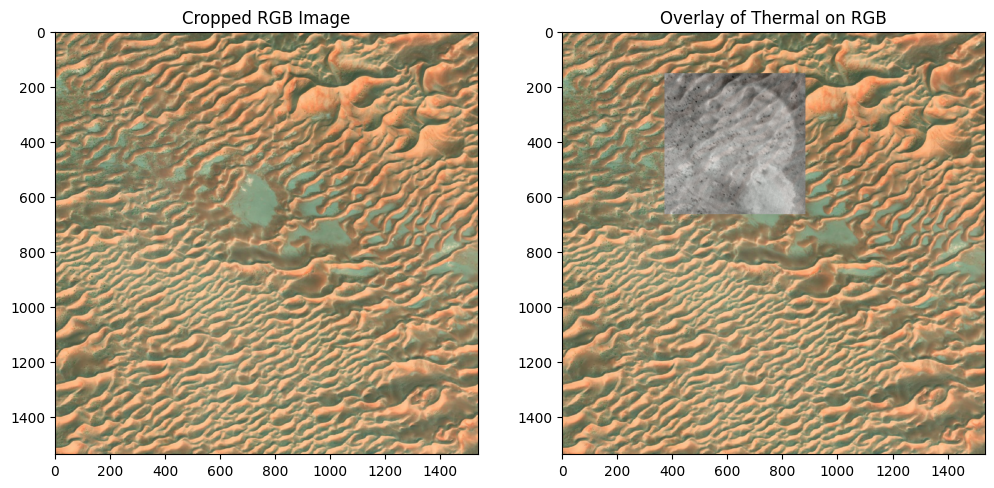

In [7]:
center, rgb_crop, thermal_patch, top, left, thermal_top, thermal_left =  get_random_crop_pairs(centers[160],rgb_zone2_array, thermal_patch=thermal_patches[160]) #get_random_crop_pairs((2000,5500),rgb_zone1_array, thermal_base_array= thermal_zone1_array)
plot_overlay(center, rgb_crop, thermal_patch, top , left, thermal_top, thermal_left)

In [10]:
# load each image as a torch.Tensor on GPU with shape (3,H,W), normalized in [0,1]

# Step 1: Convert to torch.Tensor and normalize to [0, 1]
tensor_image_crop = torch.tensor(rgb_crop, dtype=torch.float32) / 255.0

# Step 2: Change the shape from (H, W, 3) to (3, H, W)
tensor_image_crop = tensor_image_crop.permute(2, 0, 1)  # (C, H, W)

# Step 3: Move the tensor to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tensor_image_crop = tensor_image_crop.to(device)

# Step 1: Convert to torch.Tensor and normalize to [0, 1]
tensor_image_patch = torch.tensor(thermal_patch, dtype=torch.float32) / 255.0

# Step 2: Change the shape from (H, W, 3) to (3, H, W)
tensor_image_patch = tensor_image_patch.permute(2, 0, 1)  # (C, H, W)

# Step 3: Move the tensor to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tensor_image_patch = tensor_image_patch.to(device)

image0 = torch.stack([tensor_image_crop, tensor_image_crop]).to(device)
image1 = torch.stack([tensor_image_patch, tensor_image_patch]).to(device)

#image0 = load_image("im1.jpeg").cuda()
#image1 = load_image("im2.jpeg").cuda()


In [11]:
image0.shape

torch.Size([2, 3, 1536, 1536])

In [13]:
# extract local features
feats0 = extractor.extract(image0[0])  # auto-resize the image, disable with resize=None
feats1 = extractor.extract(image1[0])

In [14]:
feats0

{'keypoints': tensor([[[1335.2961,  349.7786],
          [ 195.0140, 1105.2367],
          [ 915.2876, 1415.3837],
          ...,
          [ 660.4873,  403.8356],
          [ 971.2303, 1221.4724],
          [ 226.8904,  437.8745]]], device='cuda:0'),
 'scales': tensor([[3.9878, 7.2593, 9.0074,  ..., 2.4768, 3.5123, 3.9270]],
        device='cuda:0'),
 'oris': tensor([[0.9044, 0.7547, 1.0383,  ..., 4.2825, 0.9845, 1.0446]],
        device='cuda:0'),
 'descriptors': tensor([[[0.0010, 0.0010, 0.0187,  ..., 0.0495, 0.0187, 0.0010],
          [0.0610, 0.0415, 0.0656,  ..., 0.1244, 0.0169, 0.0239],
          [0.1181, 0.0827, 0.0165,  ..., 0.0438, 0.0165, 0.0438],
          ...,
          [0.2320, 0.1003, 0.0417,  ..., 0.0697, 0.1070, 0.0968],
          [0.0273, 0.0010, 0.0010,  ..., 0.0610, 0.0010, 0.0010],
          [0.0778, 0.0301, 0.0348,  ..., 0.1414, 0.1193, 0.0460]]],
        device='cuda:0'),
 'keypoint_scores': tensor([[0.0316, 0.0271, 0.0277,  ..., 0.0147, 0.0147, 0.0147]],
       

In [23]:
# match the features
matches01 = matcher({'image0': feats0, 'image1': feats1})
feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension
matches = matches01['matches']  # indices with shape (K,2)
points0 = feats0['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
points1 = feats1['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)

ValueError: not enough values to unpack (expected 3, got 2)

In [24]:
matches01

{'matches0': tensor([-1, -1, -1,  ..., -1, -1, -1], device='cuda:0'),
 'matches1': tensor([-1, -1, -1,  ..., -1, -1, -1], device='cuda:0'),
 'matching_scores0': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0',
        grad_fn=<SelectBackward0>),
 'matching_scores1': tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0',
        grad_fn=<SelectBackward0>),
 'stop': 9,
 'matches': tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64),
 'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>),
 'prune0': tensor([9., 9., 9.,  ..., 9., 9., 9.], device='cuda:0'),
 'prune1': tensor([9., 9., 9.,  ..., 9., 9., 9.], device='cuda:0')}

In [25]:
matches[..., 1]

tensor([], device='cuda:0', dtype=torch.int64)

In [26]:
from lightglue import match_pair
feats0, feats1, matches01 = match_pair(extractor, matcher, image0, image1)

AssertionError: 

In [19]:
feats0["keypoints"].shape, feats1["keypoints"].shape

(torch.Size([3372, 2]), torch.Size([3476, 2]))

In [20]:
matches01["matches0"][matches01["matches0"] > 0 ]

tensor([], device='cuda:0', dtype=torch.int64)

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2  # For resizing the image

# Assume image0 and image1 are tensors with shape (C, H, W)
# Convert from (C, H, W) to (H, W, C)
image0 = image0.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
image1 = image1.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)

# Normalize the image if it's in the range [0, 255] (optional)
# If the images are already normalized, you can skip this step
if image0.max() > 1.0:
    image0 = image0 / 255.0
    image1 = image1 / 255.0

# Ensure points0 and points1 are in numpy format if they are in torch format
points0 = points0.cpu().numpy()
points1 = points1.cpu().numpy()

# Get the width and height of both images
height0, width0 = image0.shape[:2]
height1, width1 = image1.shape[:2]

# Resize image1 to match image0's size
image1_resized = cv2.resize(image1, (width0, height0), interpolation=cv2.INTER_LINEAR)

# Calculate scale factors for resizing points1 to match image0's size
scale_x = width0 / width1
scale_y = height0 / height1

# Scale points1 to match the scale of image0
points1_scaled = points1 * np.array([scale_x, scale_y])

# Create a larger canvas to hold both images side by side
# Ensure combined_image can hold both images correctly
combined_image = np.zeros((height0, width0 + width0, 3), dtype=np.float32)

# Place image0 on the left side of the canvas
combined_image[:, :width0] = image0

# Place resized image1 on the right side of the canvas (after image0)
combined_image[:, width0:width0 + width0] = image1_resized

# Create a figure and axis to display the combined image
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the combined image
ax.imshow(combined_image)

# Plot the keypoints from image0 (in red)
ax.scatter(points0[:, 0], points0[:, 1], color='r', s=10)  # Keypoints on image0

# Plot the keypoints from image1 (in blue), shifted to the right
ax.scatter(points1_scaled[:, 0] + width0, points1_scaled[:, 1], color='b', s=10)  # Keypoints on image1

# Draw lines connecting the matching keypoints between the two images
for p0, p1 in zip(points0, points1_scaled):
    ax.plot([p0[0], p1[0] + width0], [p0[1], p1[1]], 'g-', lw=1)  # Connecting line

# Set the title and turn off the axes
ax.set_title("Matches Between Image 0 and Image 1 (Resized)")
ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()



RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3